In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import *

%load_ext autoreload
%autoreload 1

# Task 4 Part 1

The logistic map is a discrete-time demographic function used to model population growth, which can be defined numerically as $$x_{n+1}=rx_n(1-x_n), n\in \mathbb{N}$$
in which $x_n$ is the population at time $n$, and $r\in (0,4]$ is a parameter that determines the rate of growth. For certain values of $r$, the logistic map exhibits chaotic behavior.

In [2]:
def logistic_map(x, rate):
    '''
    Definition of the equation for the logistic map.
    :param x: float
        current population value at time t
    :param rate: float
        growth rate parameter values
    :returns: float
        scalar result of logistic map at time t+1
    '''
    return rate * x * (1 - x)
    
def get_function_points(model, r, n, start, end):
    '''
    Calculate the model results x_{i+1} for n x_i values evenly spaced between [start, end] period.
    :param model: function
        a defined iterated map to simulate
    :param r: float
        growth rate parameter value to pass to the map function
    :param n: int
        number of different x_i to space and calculate
    :param start: float
        lower limit of the function range
    :param end: float
        upper limit of the function range
    :returns: tuple
        x_vals, y_vals: tuple of the x_i series and its corresponding x_{i+1} values
    '''
    x_vals = np.linspace(start, end, n)
    y_vals = [model(x, r) for x in x_vals]
    return x_vals, y_vals

def get_cobweb_points(model, r, x, n):
    '''
    Based on pynamical `https://github.com/gboeing/pynamical`
    Calculate the vertices of cobweb lines for a cobweb plot.

    Steps in the calculation:
    1) Let x = 0.5
    2) Start on the x-axis at the point (x, 0).
    3) Draw a vertical line to the red function curve: this point has the coordinates (x, f(x)).
    4) Draw a horizontal line from this point to the gray diagonal line: this point has the coordinates (f(x), f(x)).
    5) Draw a vertical line from this point to the red function curve: this point has the coordinates (f(x), f(f(x))).
    6) Repeat steps 4 and 5 recursively one hundred times.

    :param model: function
        a defined iterated map to simulate
    :param r: float
        growth rate parameter value to pass to the map function
    :param x: float
        starting population value
    :param n: int
        number of iterations to run
    :returns: tuple
        x0_vals, cobweb_y_vals： tuple of the iterated (x_i, x_{i+1}) position series
    '''
    cobweb_points = [(x, 0)]
    for _ in range(n):
        y1 = model(x, r)
        cobweb_points.append((x, y1))
        cobweb_points.append((y1, y1))
        y2 = model(y1, r)
        cobweb_points.append((y1, y2))
        x = y1
    return zip(*cobweb_points)

In [3]:
# define a color palette for visualization
colors =  ["#101010", "#b03010", "#1090d0", "#7090b0", "#303030"]

In [4]:
def bifurc(model=logistic_map, r=0, x0=0.5,
           function_n=512, cobweb_n=128, discard=64, tail=16,
           start=0, end=1, fig_output=False):
    '''
    Calculate and plot the series plot, cobweb plot and bifurcation plot of the model.
    Results given by updating calculated coordinates of the points on the bifurcation plot
    into global lists xs_record and ys_record.

    :param model: function
        a defined iterated map to simulate
    :param r: float
        growth rate parameter value to pass to the map function
    :param x0: float
        starting population value
    :param function_n: int
        number of different x_i to space and calculate function points
    :param cobweb_n: int
        number of iterations for calculating cobweb points
    :param discard: int
        number of iterations for the function value to reach stable state
    :param tail: int
        number of iterations at last to keep as converged points on bifurcation plot
    :param start: float
        lower limit of the function range
    :param end: float
        upper limit of the function range
    :param fig_output: bool
        controller of generating the series plot, cobweb plot and 
        bifurcation plot of the model or not
    :returns: none
    '''
    # ax0: series plot,  ax1: cobweb plot,  ax2: bifurcation plot
    if fig_output:
        fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(25,8))

    func_x_vals, func_y_vals = get_function_points(
        model=model, r=r, n=function_n, start=start, end=end)
    cobweb_x_vals, cobweb_y_vals = get_cobweb_points(
        model=model, r=r, x=x0, n=cobweb_n)

    # cobweb plot        
    if fig_output:
        # dynamic sizes for plotting points on the cobweb plot
        sizes = 1/np.linspace(.1,1,cobweb_n)
        sizes = np.maximum(16, sizes*sizes)

        diagonal_line = ax1.plot([0,1], [0,1], color=colors[4], linewidth=1.2)
        function_line = ax1.plot(func_x_vals, func_y_vals, color=colors[2], linewidth=2)
        cobweb_line = ax1.plot(cobweb_x_vals, cobweb_y_vals, color=colors[3], linewidth=1, alpha=0.6)
        cobweb_scatter = ax1.scatter(cobweb_x_vals, cobweb_y_vals, sizes=sizes, c=colors[1], alpha=0.6)
        ax1.set_title("Cobweb Plot")
        ax1.set_xlabel(r'$x_i$')
        ax1.set_ylabel(r'$x_{i+1}$')
        ax1.set_xlim(xmin=-0.05, xmax=1.05)
        ax1.set_ylim(ymin=-0.05, ymax=1.05)

    # calculate x_t values on the series plot for different t
    # the [1::3] here is because we get 1 useful x_t result from every 3 points in the cobweb plot,
    # as the other 2 auxillary points have exactly the same value.
    y_vals = np.concatenate(([float(x0),], np.array(cobweb_y_vals[1::3])))    
    
    # series plot
    if fig_output:
        # only select the [0~discard] range for the series plot, 
        # as this shows the part where the function converges
        t = np.arange(len(y_vals))
        y = y_vals[:discard]
        t = t[:discard]
        s = np.repeat(24, len(t))
        series_line = ax0.plot(t, y, color=colors[3], linewidth=1)
        series_scatter = ax0.scatter(t, y, sizes=s, c=colors[1])
        ax0.set_title("Series Plot")
        ax0.set_xlabel(r'$t$')
        ax0.set_ylabel(r'$x_t$')
        ax0.set_ylim(ymin=-0.05, ymax=1.05)

    global xs_record, ys_record

    # take tail elements at last as converged stable results
    ys = y_vals[-tail:]
    xs = np.repeat(r,len(ys))
    
    # store the calculated coordinates of points in bifurcation graph
    if not fig_output:
        xs_record = np.concatenate([xs_record, xs], axis=0)
        ys_record = np.concatenate([ys_record, ys], axis=0)
    
    # bifurcation plot
    else:
        bifurcation_all = ax2.scatter(xs_record, ys_record, s=0.5, c=colors[2], alpha=0.5)
        bifurcation_current = ax2.scatter(xs, ys, s=32, c=colors[1])
        ax2.set_title("Bifurcation Plot")
        ax2.set_xlabel(r'$r$')
        ax2.set_ylabel(r'$x_\infty$')
        ax2.set_xlim(xmin=-0.05, xmax=4.05)
        #fig.show()

In [5]:
# store the calculated coordinates of points in bifurcation graph
xs_record = np.array([0])
ys_record = np.array([0])

# calculate for 2048 different r values 
for r in np.linspace(0, 4, 2048):
    bifurc(r=r, fig_output = False)

The following part should create an interactive user-interface for 3 different plots based on selected $r$ and $x_0$.

In [6]:
def bar(r, x0):
    bifurc(r=r, x0=x0, fig_output = True)

interact(bar, r=widgets.FloatSlider(min=0, max=4, step=0.01, value=3.8),
              x0=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.2))

interactive(children=(FloatSlider(value=3.8, description='r', max=4.0, step=0.01), FloatSlider(value=0.2, desc…

<function __main__.bar(r, x0)>

The following code is to print a zoom-in of bifurcation diagram.

(0.25, 0.95)

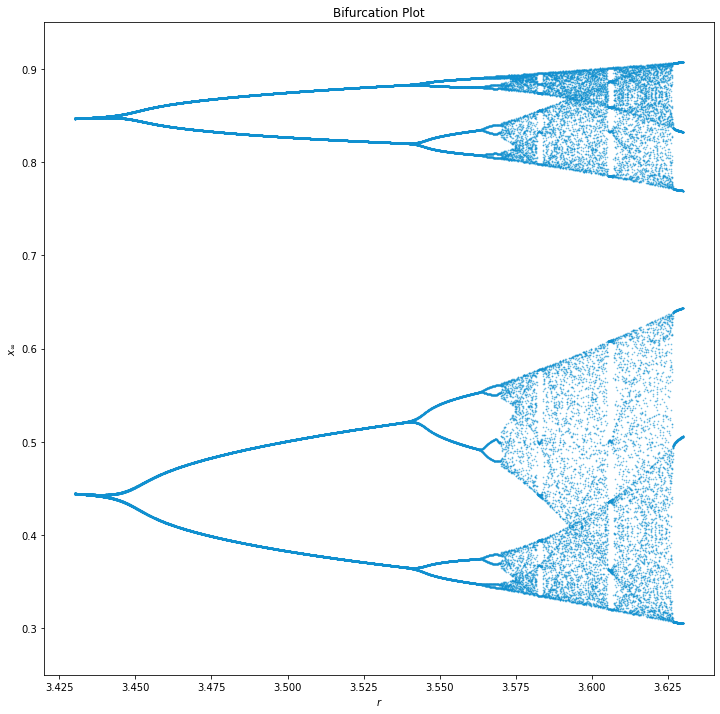

In [7]:
# store the calculated coordinates of points in bifurcation graph
xs_record = np.array([0])
ys_record = np.array([0])

# calculate for 4096 different r values between a smaller range 
# for plotting a zoom-in bifurcation diagram
for r in np.linspace(3.43, 3.63, 4096):
    bifurc(r=r, fig_output = False)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(xs_record, ys_record, s=0.5, c=colors[2], alpha=0.5)
ax.set_title("Bifurcation Plot")
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$x_\infty$')
ax.set_xlim(xmin=3.42, xmax=3.64)
ax.set_ylim(ymin=0.25, ymax=0.95)